In [6]:
import os
import pandas as pd
import pingouin as pg
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")
from statsmodels.graphics.factorplots import interaction_plot
import numpy as np
from sklearn.metrics import cohen_kappa_score
from scipy import stats

In [2]:
def compute_anova(df, dependent_v):
    """

    Args:
        df: data frame that contains the data
        dependent_v: dependent variable

    Returns:

    """
    aov = pg.mixed_anova(dv=dependent_v, within='mode', between='condition', subject='id', data=df)
    # printing of ANOVA summary
    pg.print_table(aov)


In [3]:
def check_assumptions(df, dv, dv_name):
    '''
    Checks the assumptions of a mixed ANOVA.

    df (pd.DataFrame)
    dv (str): dependent variable column name
    dv_name (str): name of the dependent variable (to be printed)
    '''

    print("Checking the assumptions for the dependent variable {}...\n".format(dv_name))
    all_assumptions = []

    # Assumption of the residuals being normally distributed
    df['factor_comb'] = df["condition"] + '-'+ df["mode"]
    normal = pg.normality(data=df, dv=dv, group='factor_comb')
    if normal["normal"].all():
        print("The residuals are approximately normally distributed for each level of the within-subjects factor (tested using the Shapiro-Wilks Test)")
        all_assumptions.append(True)
    else:
        print("The residuals are NOT approximately normally distributed for each level of the within-subjects factor! (tested using the Shapiro-Wilks Test)")
        all_assumptions.append(False)

    print()
    # Assumption of homoscedasticity
    print("There should be equal variance for every level of within-subject factor:")
    hybrid = df[df["mode"]=="Hybrid"].reset_index(drop=True)
    homo_hybrid = pg.homoscedasticity(data=hybrid, dv=dv, group='condition')
    all_assumptions.append(homo_hybrid["equal_var"][0])
    print("For the level Hybrid, Levene's test resulted in a p-value of {}, indicating that the assumption of equal variances is {}.".format(homo_hybrid["pval"][0].round(3), homo_hybrid["equal_var"][0]))

    fp = df[df["mode"]=="Firstperson"].reset_index(drop=True)
    homo_fp = pg.homoscedasticity(data=fp, dv=dv, group='condition')
    all_assumptions.append(homo_fp["equal_var"][0])
    print("For the level First Person, Levene's test resulted in a p-value of {}, indicating that the assumption of equal variances is {}.".format(homo_fp["pval"][0].round(3), homo_fp["equal_var"][0]))

    print()
    # Assumption of sphericity
    sphericity = pg.sphericity(data=df, dv=dv, subject='id', within='condition')
    all_assumptions.append(sphericity[0])
    print("Mauchly’s test of sphericity resulted in a p-value of {}, indicating that the assumption is {}.".format(sphericity[-1], sphericity[0]))

    print()
    # Assumption of homogeneity of the variance-covariance matrices:
    print("The homogeneity of variance-covariance matrices formed by the between-subject factor for each level of the within-subject factor should be equal:")
    box_fp = pg.box_m(data=fp, dvs=[dv], group='condition', alpha=0.001)
    all_assumptions.append(box_fp["equal_cov"][0])
    print("For the level First Person, Box’s M test resulted in a p-value of {}, indicating that the assumption is {}.".format(box_fp["pval"][0].round(3), box_fp["equal_cov"][0]))

    box_hybrid = pg.box_m(data=hybrid, dvs=[dv], group='condition', alpha=0.001)
    all_assumptions.append(box_hybrid["equal_cov"][0])
    print("For the level Hybrid, Box’s M test resulted in a p-value of {}, indicating that the assumption is {}.".format(box_hybrid["pval"][0].round(3), box_hybrid["equal_cov"][0]))

    print()
    # Assumption of no outliers
    #outliers = df[df[dv] > df[dv].mean() + 3 * df[dv].std()]
    outliers = df[np.abs(df[dv] - df[dv].mean()) > (3 * df[dv].std())]
    print("A data point is called an outlier if it > 3 sd away from the mean.")
    if outliers.empty:
        print("There are no outliers!")
        all_assumptions.append(True)
    else:
        print("There are outliers! The outliers are the participants {}".format(outliers["id"].values))
        print(outliers)
        all_assumptions.append(False)


    if all(x == True for x in all_assumptions):
        print()
        print("ALL ASSUMPTIONS ARE TRUE!")

In [5]:
#/home/yesid/Documents/Master_semester3/VR/text_analysis_task/clean_transcription/joined_ratings.csv
#path to csv file with transcriptions and joned ratings
file_transcription= input()
df_transcription = pd.read_csv(file_transcription)

In [79]:
file_velocities = input()
#/home/yesid/Documents/Master_semester3/VR/postural_stability_analysis/data/all_velocities_.csv
df_velocities = pd.read_csv(file_velocities)
df_velocities = df_velocities[['id', 'condition', 'mode', 'condition_mode', 'station',
       'time_frame_begin', 'time_frame_end', 'motion_sickness_score',
       'name_of_audio_data', 'motionsickness_score_rating_begin',
       'motionsickness_score_rating_accepted_timeStamp', 'average_velocity']]

## Cohen's Kappa
### Rating transcriptions:
- Transcriptions were anonymized so that raters did not know what condition, mode or id a transcription belonged to.
- Raters were handed out a csv file with a sample of the transcriptions. This file contained two columns:
    - id_transcription: a coded representation of the id, condition and mode. (Raters did not know what this code stood for.)
    - transcription: text with the audio file transcription.
    - rating: raters fill out this column with any of the following:
        - 0: which stood for undefined. The transcription was neither first person nor third person.
        - 1: which stood for first person.
        -  3: which stood for third person.

- The rating process was carried out in two iterations:
    - Iteration 1: raters were handed out samples of the transcriptions.
    - Iteration 2: raters were handed out a **different** sample of the transcriptions.

In this section we will use Cohen's Kappa to measure the inter-raters agreement.
https://scikit-learn.org/stable/modules/generated/sklearn.metrics.cohen_kappa_score.html


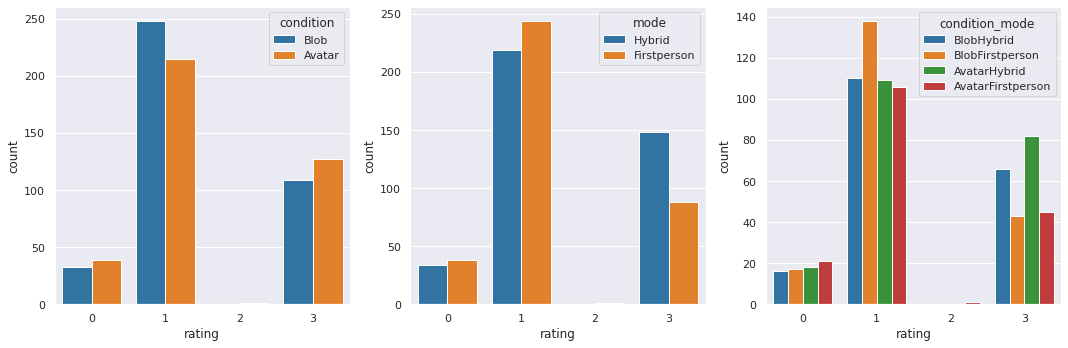

In [67]:
def plots_transcription (df_description):
    """
    Gives an overview of the transcription data
    Args:
        df_description: data frame with the transcription and respective ratings

    Returns:

    """
    fig = plt.figure(figsize=(15, 5))
    ax1 = fig.add_subplot(131)
    sns.countplot(x="rating", hue='condition',palette="tab10", data=df_transcription,  ax=ax1)
    ax2 = fig.add_subplot(132)
    sns.countplot(x="rating", hue='mode',palette="tab10", data=df_transcription, ax=ax2)
    ax3 = fig.add_subplot(133)
    sns.countplot(x="rating", hue='condition_mode',palette="tab10", data=df_transcription, ax=ax3)


    plt.tight_layout()

plots_transcription(df_transcription)

The effect of the condition/treatment on the dependent variable -- whether someone is speaking in first, third person or undefined-- does or does not depend on the mode.

In [12]:
check_assumptions(df_transcription,'rating','rating')

Checking the assumptions for the dependent variable rating...

The residuals are NOT approximately normally distributed for each level of the within-subjects factor! (tested using the Shapiro-Wilks Test)

There should be equal variance for every level of within-subject factor:
For the level Hybrid, Levene's test resulted in a p-value of 0.289, indicating that the assumption of equal variances is True.
For the level First Person, Levene's test resulted in a p-value of 0.15, indicating that the assumption of equal variances is True.

Mauchly’s test of sphericity resulted in a p-value of 1.0, indicating that the assumption is True.

The homogeneity of variance-covariance matrices formed by the between-subject factor for each level of the within-subject factor should be equal:
For the level First Person, Box’s M test resulted in a p-value of 0.205, indicating that the assumption is True.
For the level Hybrid, Box’s M test resulted in a p-value of 0.646, indicating that the assumption is Tr

In [4]:
aov = pg.mixed_anova(dv='rating', within='mode', between='condition', subject='id', data=df_transcription)
# Pretty printing of ANOVA summary
pg.print_table(aov)


ANOVA SUMMARY

Source          SS    DF1    DF2     MS       F    p-unc    np2      eps
-----------  -----  -----  -----  -----  ------  -------  -----  -------
condition    0.281      1     81  0.281   0.432    0.513  0.005  nan
mode         3.086      1     81  3.086  12.827    0.001  0.137    1.000
Interaction  0.006      1     81  0.006   0.024    0.877  0.000  nan



## Postural Stability Test

In [100]:
df_velocities.head()

,id,condition,mode,condition_mode,station,time_frame_begin,time_frame_end,motion_sickness_score,name_of_audio_data,motionsickness_score_rating_begin,motionsickness_score_rating_accepted_timeStamp,average_velocity,factor_comb
0,1,Blob,hybrid,BlobHybrid,1,1.637653e+09,1.637653e+09,0,001_BlobHybrid_1,1.637653e+09,1.637653e+09,0.007961,Blob-hybrid
1,1,Blob,Firstperson,BlobFirstperson,3,1.637656e+09,1.637656e+09,0,001_BlobFirstperson_3,1.637656e+09,1.637656e+09,0.006391,Blob-Firstperson
2,1,Blob,Firstperson,BlobFirstperson,1,1.637656e+09,1.637656e+09,0,001_BlobFirstperson_1,1.637656e+09,1.637656e+09,0.006688,Blob-Firstperson
3,1,Blob,Firstperson,BlobFirstperson,2,1.637656e+09,1.637656e+09,0,001_BlobFirstperson_2,1.637656e+09,1.637656e+09,0.008408,Blob-Firstperson
4,1,Blob,Firstperson,BlobFirstperson,0,1.637655e+09,1.637655e+09,0,001_BlobFirstperson_0,1.637655e+09,1.637655e+09,0.006033,Blob-Firstperson


### Visualizations
Before conducting any analysis we will visually explore the data.

#### Data distribution
Below you can find the distribution of the average velocity by condition + mode and, condition alone. As one can easily tell, their distributions do not differ much from each other.

<AxesSubplot:title={'center':'Motion Sickness Score'}, xlabel='average_velocity', ylabel='Frequency'>

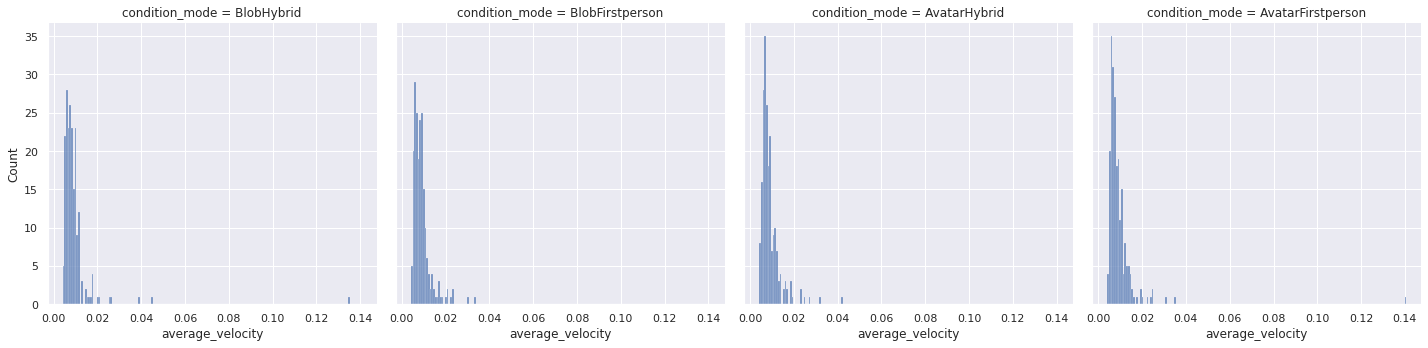

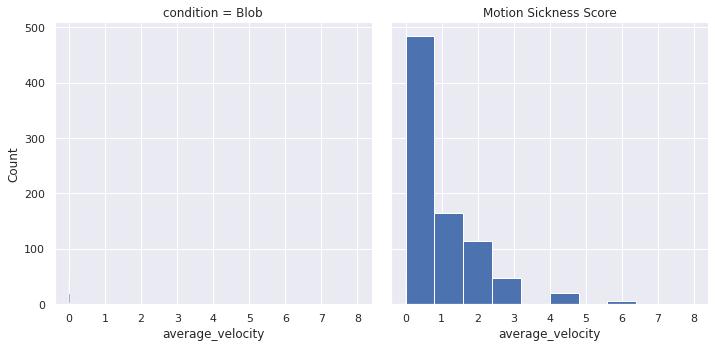

In [82]:
sns.displot(df_velocities, x="average_velocity", col='condition_mode')
# Divide the figure into a 1x2 grid
sns.displot(df_velocities, x="average_velocity",col ='condition')

The average velocity tends to 0, as it is shown above. On ther hand, if we observe the distribution of the motion sickness scores (below) we can see that it is skewed to the left: most participants said not to have been motion sick. The average velocity, as long as it is a measurement of sickness, seems to back up the motion sickness scores obtained.

<AxesSubplot:title={'center':'Motion Sickness Score'}, ylabel='Frequency'>

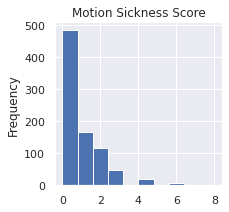

In [90]:
df_velocities['motion_sickness_score'].plot(kind ='hist', title='Motion Sickness Score', figsize=(3,3))

#### Boxplot
As the two boxplot below show, the data contain several outliers.

<AxesSubplot:xlabel='station', ylabel='average_velocity'>

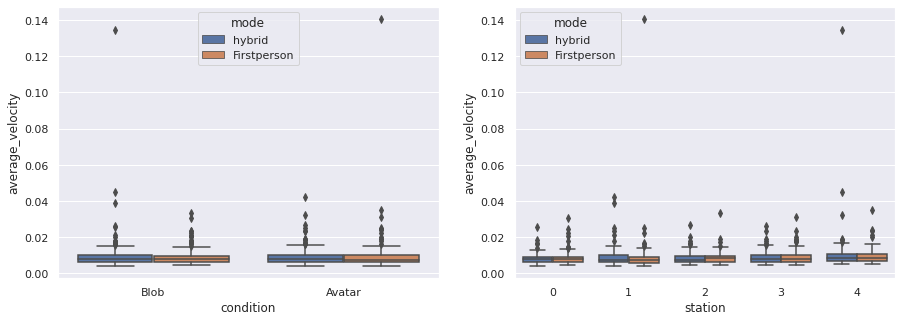

In [86]:
sns.set(rc = {'figure.figsize':(11,8)})
fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(121)
sns.boxplot(x='condition', y='average_velocity', hue='mode', data=df_velocities, ax=ax1)
ax2 = fig.add_subplot(122)
sns.boxplot(x='station', y='average_velocity', hue='mode', data=df_velocities,ax=ax2)

<AxesSubplot:xlabel='mode', ylabel='average_velocity'>

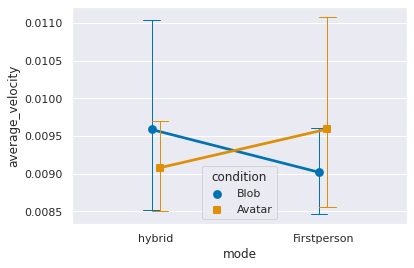

In [84]:
sns.pointplot(data=df_velocities, x='mode', y='average_velocity', hue='condition', dodge=True, markers=['o', 's'],
	      capsize=.1, errwidth=1, palette='colorblind')

### Descriptive Statistics

In [92]:
df_velocities.groupby(['condition']).describe()['average_velocity']

,count,mean,std,min,25%,50%,75%,max
condition,,,,,,,,
Avatar,430.0,0.009340,0.007748,0.004114,0.006415,0.007750,0.010220,0.140646
Blob,410.0,0.009301,0.007647,0.004218,0.006396,0.008077,0.009965,0.134691


### Mixed ANOVA

#### Description of the analysis

- Between subject variable (factor): Condition (Avatar, Blob) each subject is assigned only once to treatment.
- Within subject: subject assigned both treatments (Hybrid, first person)
- Dependent variable: average_velocity

In [98]:
# Compute the two-way mixed-design ANOVA
compute_anova(df_velocities, 'average_velocity')


ANOVA SUMMARY

Source          SS    DF1    DF2     MS      F    p-unc    np2      eps
-----------  -----  -----  -----  -----  -----  -------  -----  -------
condition    0.000      1     80  0.000  0.083    0.774  0.001  nan
mode         0.000      1     80  0.000  0.762    0.385  0.009    1.000
Interaction  0.000      1     80  0.000  0.540    0.464  0.007  nan



At a significance level 0.05, we can say that there is no significant interaction effect. The effect of the condition/treatment on the average velocity (dependent variable) does not depend on the mode or perspective (Hybrid/Firstperson). Hence, whether someone is motion sick (high velocity) or not (low velocity) does not depend on the perspective used to navigate the VR environment.

#### Assumption check

In [101]:
check_assumptions(df_velocities,'average_velocity', 'average_velocity')

Checking the assumptions for the dependent variable average_velocity...

The residuals are NOT approximately normally distributed for each level of the within-subjects factor! (tested using the Shapiro-Wilks Test)

There should be equal variance for every level of within-subject factor:


AssertionError: Data must have at least two columns.